# Commodity Price Prediction Model

This notebook is used to carry out the ETL, EDA and Model experiments of the data downloaded from Alpha-Advantage API. The steps would be:

    1. Create a pipeline to download the dataset using the API
    2. Carry out and preliminary EDA on the data to determining the initial cleaning requirements.
    3. Add the cleaning steps to the pipeline.
    4. Carry out a full EDA on the data to determine additional transformations required and modelling technique(s) to explore.
    5. Split the data 
    6. Create the model(s) and evaluate accordingly to select the best model(s)
    7. Save best model to utilise in the web app.

In [1]:
# Import the required libraries for ETL and EDA

# Data wrangling and visusalisation libraries
import plotly.express as px
from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Environment variables and file management libraries
from dotenv import load_dotenv
import os

# API Library
from alpha_vantage.commodities import Commodities

# Statistical libraries
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Model Evaluation libraries
from sklearn.metrics import mean_squared_error, root_mean_squared_error

# Time Series Models
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from prophet import Prophet
from prophet.plot import plot_plotly



In [3]:
# Initialise the environment variable  and load the API_Key
load_dotenv(override=True)

# Load the API_KEY
api_key = os.getenv('api_key')

`We will create a pipeline that will extract, clean and save the data programmatically from the API. This would be built step by step below by adding components as the EDA is being done. The ETL code would be transfered to a Python Script.`

In [ ]:
# Create a data extraction Pipeline. This will be updated as the 
class CommodityData:
    """"
    This class objects defines the data extraction, transformation, cleaning and loading stage of the application"""

    def __init__(self, api_key=api_key):
        """ Initiates the class object with the api_key.
        Sets the base directory      
        
        """
        self.api_key=api_key
        self.cd = Commodities(self.api_key)

        base_dir = os.path.abspath(os.path.dirname(__file__))
        self.data_dir = os.path.join(base_dir, 'data')


    def etl_commodity_data(self, commodity, interval, start_date , end_date):
        """" Extract data from alpha-vantage APi and save into csv if not already downloaded
        
        Parameters:
        commodity: The alpha-vantage commodity code 
        interval: Interval for the data - options ['daily', 'monthly', 'yearly']
        start_date: Start date for data in format YYYY-MM-DD 
        end_date: End date for data in format YYYY-MM-DD   
        """    

        # Convert string dates to datetime objects 
        start_date = datetime.strptime(start_date, '%Y-%m-%d') 
        end_date = datetime.strptime(end_date, '%Y-%m-%d')
        # today_date = datetime.strptime(str(datetime.now().strftime('%Y-%m-%d')), '%Y-%m-%d')
        
        # from IPython import get_ipython # Get the current working directory 
        # base_dir = get_ipython().run_line_magic('pwd', '')
        # Get list of files in data directory
        if commodity == 'WTI':
            wti_dir = os.path.join(self.data_dir, 'WTI')
            # Check if the directory exists and create it if it does not 
            if not os.path.exists(wti_dir): 
                os.makedirs(wti_dir)
            file = os.listdir(wti_dir)
            
            # Check if there is no existing download
            if str(end_date.strftime('%Y-%m-%d') +'.csv') not in file:
                # Download from API for commodity requested
                wti_data = self.cd.get_wti(interval)
                
                if wti_data[0].values.any() != "":
                    wti_df = pd.DataFrame(wti_data[0])
                    
                    # Transform to time-series df
                    wti_df.set_index('date', drop=True, inplace=True)
                    
                    # Convert date column to datetime
                    wti_df.index = pd.to_datetime(wti_df.index)

                    # Replace the . with nan
                    wti_df['value'] = wti_df['value'].replace('.', np.nan)                         
                        
                    # Fill missing data using backfill
                    wti_df = wti_df.bfill()

                    # Remove negative and zero values
                    wti_df = wti_df[wti_df['value'] >= 0]

                    # Load the full file to csv 
                    wti_df.to_csv(f'data/{commodity}/{str(end_date.strftime('%Y-%m-%d') +'.csv')}')

                    # Filter for the start date and end date
                    wti_df = wti_df[(wti_df.index >= start_date) & (wti_df.index <= end_date)]
                else:
                    data = pd.DataFrame() # Create an empty DataFrame if data is unavailable or response fails return
                    
                    return print("No data available - try again later")
            
                return wti_df    
                    
            else:
                wti_df = pd.read_csv(f'data/{commodity}/{str(end_date.strftime('%Y-%m-%d') +'.csv')}')
                
                # Transform to time-series df
                wti_df.set_index('date', drop=True, inplace=True)
                
                # Convert date column to datetime
                wti_df.index = pd.to_datetime(wti_df.index)
                                           
                # Replace the . with nan
                wti_df['value'] = wti_df['value'].replace('.', np.nan)        
                # Fill missing data using backfill
                wti_df = wti_df.bfill()

                # Remove negative and zero values
                wti_df = wti_df[wti_df['value'] >= 0]
                
                # Filter for the start date and end date
                wti_df = wti_df[(wti_df.index >= start_date) & (wti_df.index <= end_date)]
            return wti_df
        
        if commodity == 'brent':
            brent_dir = os.path.join(self.data_dir, 'brent')
            # Check if the directory exists and create it if it does not 
            if not os.path.exists(brent_dir): 
                os.makedirs(brent_dir)
            file = os.listdir(brent_dir)
            
            # Check if there is no existing download
            if str(end_date.strftime('%Y-%m-%d') +'.csv') not in file:
                # Download from API for commodity requested
                brent_data = self.cd.get_brent(interval)
                
                if brent_data[0].values.any() != "":
                    brent_df = pd.DataFrame(brent_data[0])
                    
                    # Transform to time-series df
                    brent_df.set_index('date', drop=True, inplace=True)
                    
                    # Convert date column to datetime
                    brent_df.index = pd.to_datetime(brent_df.index)

                    # Replace the . with nan
                    brent_df['value'] = brent_df['value'].replace('.', np.nan)                         
                        
                    # Fill missing data using backfill
                    brent_df = brent_df.bfill()

                    # Remove negative and zero values
                    brent_df = brent_df[brent_df['value'] >= 0]

                    # Load the full file to csv 
                    brent_df.to_csv(f'data/{commodity}/{str(end_date.strftime('%Y-%m-%d') +'.csv')}')

                    # Filter for the start date and end date
                    brent_df = brent_df[(brent_df.index >= start_date) & (brent_df.index <= end_date)]
                else:
                    data = pd.DataFrame() # Create an empty DataFrame if data is unavailable or response fails return
                    
                    return print("No data available - try again later")
            
                return brent_df    
                    
            else:
                brent_df = pd.read_csv(f'data/{commodity}/{str(end_date.strftime('%Y-%m-%d') +'.csv')}')
                
                # Transform to time-series df
                brent_df.set_index('date', drop=True, inplace=True)
              
                # Convert date column to datetime
                brent_df.index = pd.to_datetime(brent_df.index)
                                           
                # Replace the . with nan
                brent_df['value'] = brent_df['value'].replace('.', np.nan)        
                # Fill missing data using backfill
                brent_df = brent_df.bfill()
                # Filter for the start date and end date
                brent_df = brent_df[(brent_df.index >= start_date) & (brent_df.index <= end_date)]
            return brent_df
        


NameError: name 'config' is not defined

In [4]:
# Instantiate the alpha_vantage API object
cd = Commodities(api_key)

# CRUDE OIL (WTI)

In [5]:
# Set variables for different scenarios
commodities = ['WTI', 'brent']
interval = ['daily', 'weekly', 'monthly']


In [6]:
# Download data from API
wti_data = cd.get_wti(interval[0])

In [7]:
# Explore the type of data downloaded
type(wti_data)

tuple

In [8]:
# Explore the content of the `tuple``
wti_data

(             date  value
 0      2025-01-13  79.57
 1      2025-01-10  77.27
 2      2025-01-09      .
 3      2025-01-08  73.99
 4      2025-01-07  74.99
 ...           ...    ...
 10178  1986-01-08  25.87
 10179  1986-01-07  25.85
 10180  1986-01-06  26.53
 10181  1986-01-03  26.00
 10182  1986-01-02  25.56
 
 [10183 rows x 2 columns],
 None)

In [9]:
# Extract the DataFrame from the tuple
df = wti_data[0]

In [10]:
# Confirm the object extracted is a DataFrame
type(df)

pandas.core.frame.DataFrame

In [11]:
# Explore the top of the dataset
df.head()

date  value
0  2025-01-13  79.57
1  2025-01-10  77.27
2  2025-01-09      .
3  2025-01-08  73.99
4  2025-01-07  74.99

In [12]:
# Explore the tail of dataset
df.tail()

date  value
10178  1986-01-08  25.87
10179  1986-01-07  25.85
10180  1986-01-06  26.53
10181  1986-01-03  26.00
10182  1986-01-02  25.56

In [13]:
# Explore the general info of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10183 entries, 0 to 10182
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    10183 non-null  object
 1   value   10183 non-null  object
dtypes: object(2)
memory usage: 159.2+ KB


In [14]:
# Check for missing values
df.isna().sum()

date     0
value    0
dtype: int64

<Axes: >

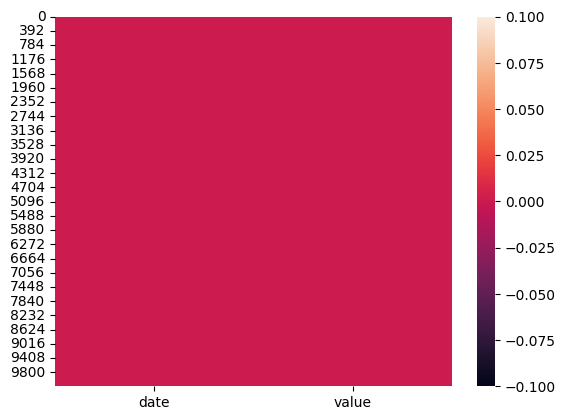

In [15]:
# Visualise for missing data
sns.heatmap(df.isnull())


We can see the following issues with the data quality with exploration done so far:

1. `date` and `value` columns have the `object` data type instead of `datetime` and `float` respectively.
2. The value has `.` as values thus not relecting as missing values

In [16]:
# Explore the instances of . as values further
len(df[df['value'] == '.'])

355

We will address these issues by:

1. Convert `date` column to datetime
2. Replace `.` values with `nan`
3. Impute missing values with backfill
4. Convert value data type to float

In [17]:
import numpy as np
# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

# Replace . with nan
df['value'] = df['value'].replace('.', np.nan)

# Impute missing values with NaN
df.bfill(inplace=True)

# Convert value column to float
df['value'] = df['value'].astype('float')

# Confirm transformation and missing values
df.info(), df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10183 entries, 0 to 10182
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    10183 non-null  datetime64[ns]
 1   value   10183 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 159.2 KB


(None,
 date     0
 value    0
 dtype: int64)

In [18]:
# Explore the descriptive statistic summary
df.describe()

date         value
count                          10183  10183.000000
mean   2005-07-08 19:11:56.606108288     47.689382
min              1986-01-02 00:00:00    -36.980000
25%              1995-10-05 12:00:00     20.215000
50%              2005-07-08 00:00:00     40.570000
75%              2015-04-11 12:00:00     71.405000
max              2025-01-13 00:00:00    145.310000
std                              NaN     29.637192

There is a negative value which is not expected for commodity prices. This should be explored further. Let's see the distribution of prices.

<Figure size 800x500 with 0 Axes>

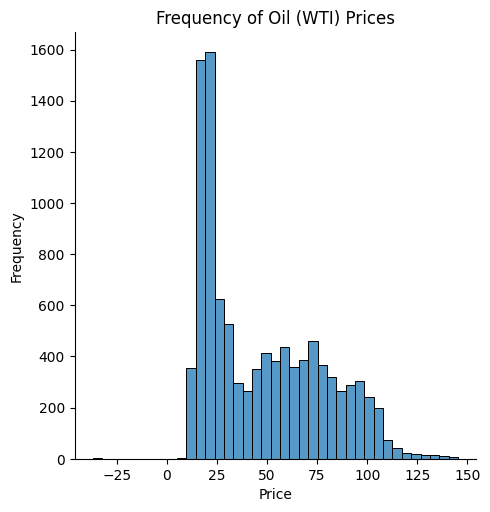

In [19]:
plt.figure(figsize=(8,5))
sns.displot(data=df, x='value')
plt.title('Frequency of Oil (WTI) Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

The data is skewed to the right with a negative value which needs to be cleaned. There instances of high crude oil prices ($120) but this is not very comongcommon

In [20]:
# Check for negative or zero values 
df[df['value'] <= 0]

date  value
1235 2020-04-20 -36.98

In [21]:
# Drop the negative value
df = df[df['value'] >= 0]

In [22]:
# Confirm the removal of negative or zero values 
df[df['value'] <= 0]

Empty DataFrame
Columns: [date, value]
Index: []

Text(0, 0.5, 'Price')

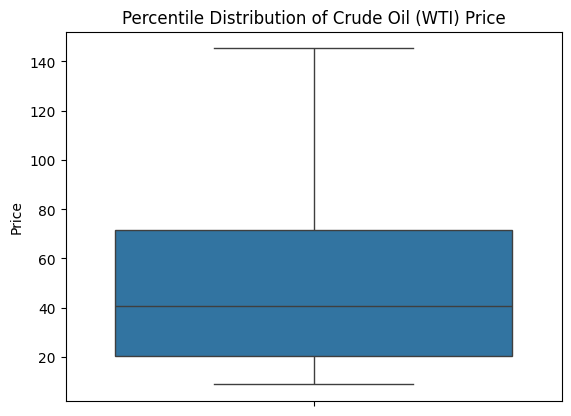

In [23]:
# Explore updated version of dataset with a boxplot
sns.boxplot(df['value'])
plt.title('Percentile Distribution of Crude Oil (WTI) Price')
plt.ylabel('Price')

In [24]:
# Convert the DataFrame to a timeseries
df.set_index('date', drop=True, inplace=True)


In [25]:
# Confirm we now have a time series dataset
df

value
date             
2025-01-13  79.57
2025-01-10  77.27
2025-01-09  73.99
2025-01-08  73.99
2025-01-07  74.99
...           ...
1986-01-08  25.87
1986-01-07  25.85
1986-01-06  26.53
1986-01-03  26.00
1986-01-02  25.56

[10182 rows x 1 columns]

### EDA of Time Series Datasetm

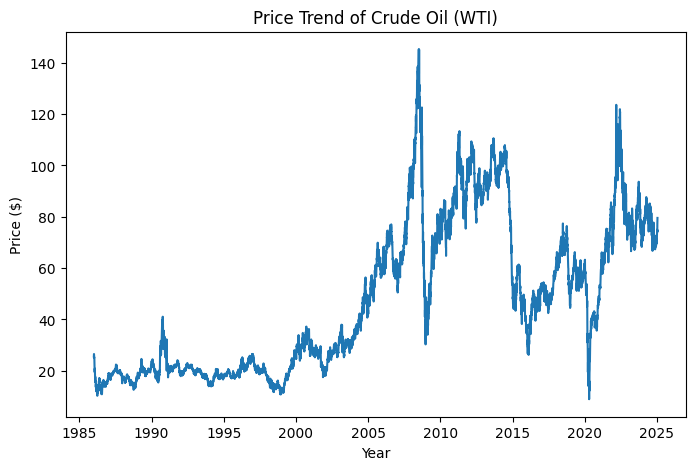

In [26]:
# Visualise the time series with a line plot
plt.figure(figsize=(8,5))
plt.plot(df)

plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.title('Price Trend of Crude Oil (WTI)');


The price was mostly with low volatilty until year 2000 from where the upward trend starts to become noticable. We can reduce our horizon from year 2000 - 2025. We will also add a monthly rolling average to smoothen the plot.

In [27]:
df1 = df[df.index >= '2000']

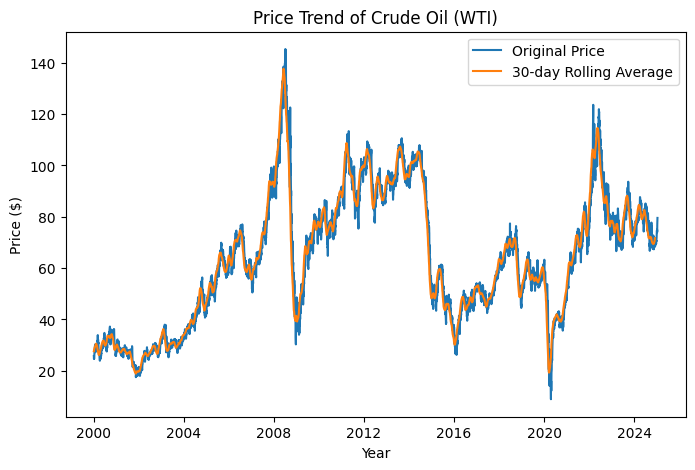

In [28]:
# Visualise the time series with a line plot from year 2000 with 
plt.figure(figsize=(8,5))
plt.plot(df1, label='Original Price')
plt.plot(df1.rolling(window=30).mean(), label='30-day Rolling Average')

plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.title('Price Trend of Crude Oil (WTI)')
plt.legend();

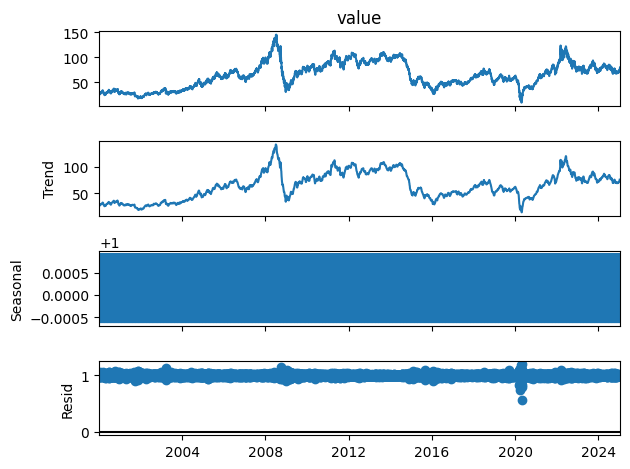

In [29]:

df1 = df1.sort_index()


result = seasonal_decompose(df1['value'] , model='multiplicative', period=7)
result.plot()
plt.show()

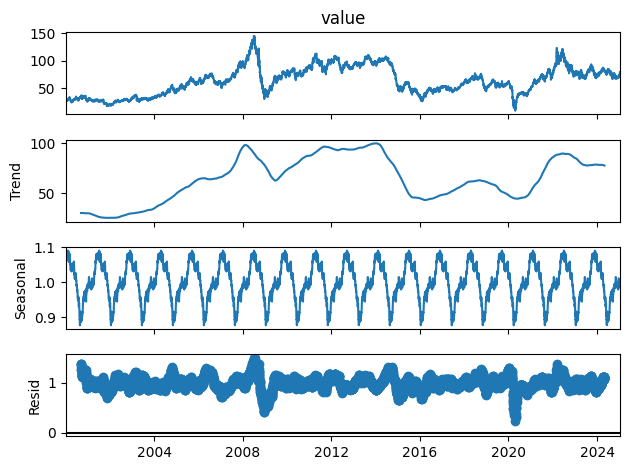

In [30]:

df1 = df1.sort_index()


result = seasonal_decompose(df1['value'] , model='multiplicative', period=365)
result.plot()
plt.show()


Original Data (value): This subplot shows the raw time series data over a period from around 2000 to 2025. There are clear fluctuations in the data with noticeable peaks and troughs, indicating variation over time.

Trend Component (Trend): This subplot isolates the underlying trend in the data. The trend component smooths out the short-term variations and highlights the long-term movement. From the plot, it looks like the trend follows a general upward trajectory over time with noticable sharp falls and gradual rise again.

Seasonal Component (Seasonal): This subplot shows the seasonal variations in the data, which are repetitive patterns that occur at regular intervals. Interestingly, in this case, the seasonal component appears to be a flat line at zero. This suggests that there are no significant seasonal patterns present in the data.

Residuals (Resid): This subplot depicts the residuals, which represent the noise or random fluctuations remaining after removing the trend and seasonal components. The residuals seem to be scattered around zero, indicating that the noise is more or less evenly distributed over time expect for the noticable time of peaks.

To summarize, the original data shows significant variation over time, with an upward trend. There are no notable seasonal patterns, and the residuals suggest that random noise is evenly spread throughout the data

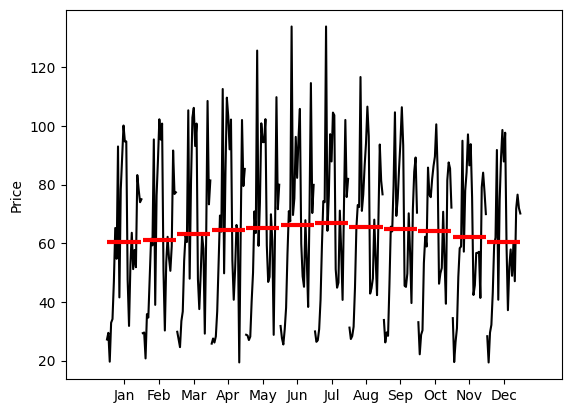

In [31]:
# let's us plot the montly and quarterly seasonality to confirm non-seasonality of the data
month_plot(df1['value'].resample('ME').mean(), ylabel='Price')
plt.show();

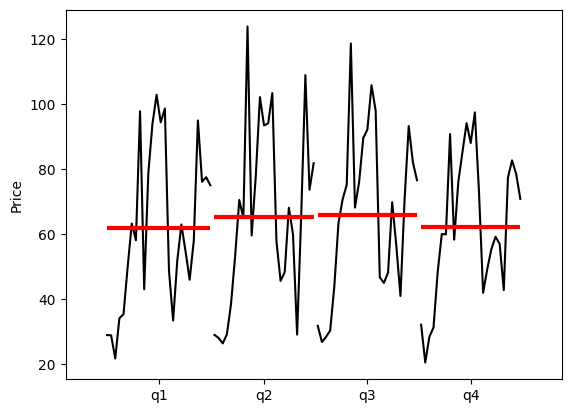

In [32]:
# let's us plot the montly and quarterly seasonality to confirm non-seasonality of the data
quarter_plot(df1['value'].resample('QE').mean(), ylabel='Price')
plt.show();

In [33]:
# Check the dataset for stationality.
# From the plots, the data is not stationary visually. We will check with ADF 
def check_stationality(series):

    result = adfuller(series)
    if result[0] < result[4]['1%']:
        print("The time series is stationary")
    elif result[1] > 0.05:
        print("The time series is not stationary")

    print('ADF Statistics:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])

In [34]:
check_stationality(df1)

The time series is not stationary
ADF Statistics: -2.6243152751365804
p-value: 0.08807520221847703
Critical Values: {'1%': np.float64(-3.431355824531222), '5%': np.float64(-2.8619844883042034), '10%': np.float64(-2.5670065977687684)}


`This suggest a non-stationary time series. We will investigate further with ACF and PACF`

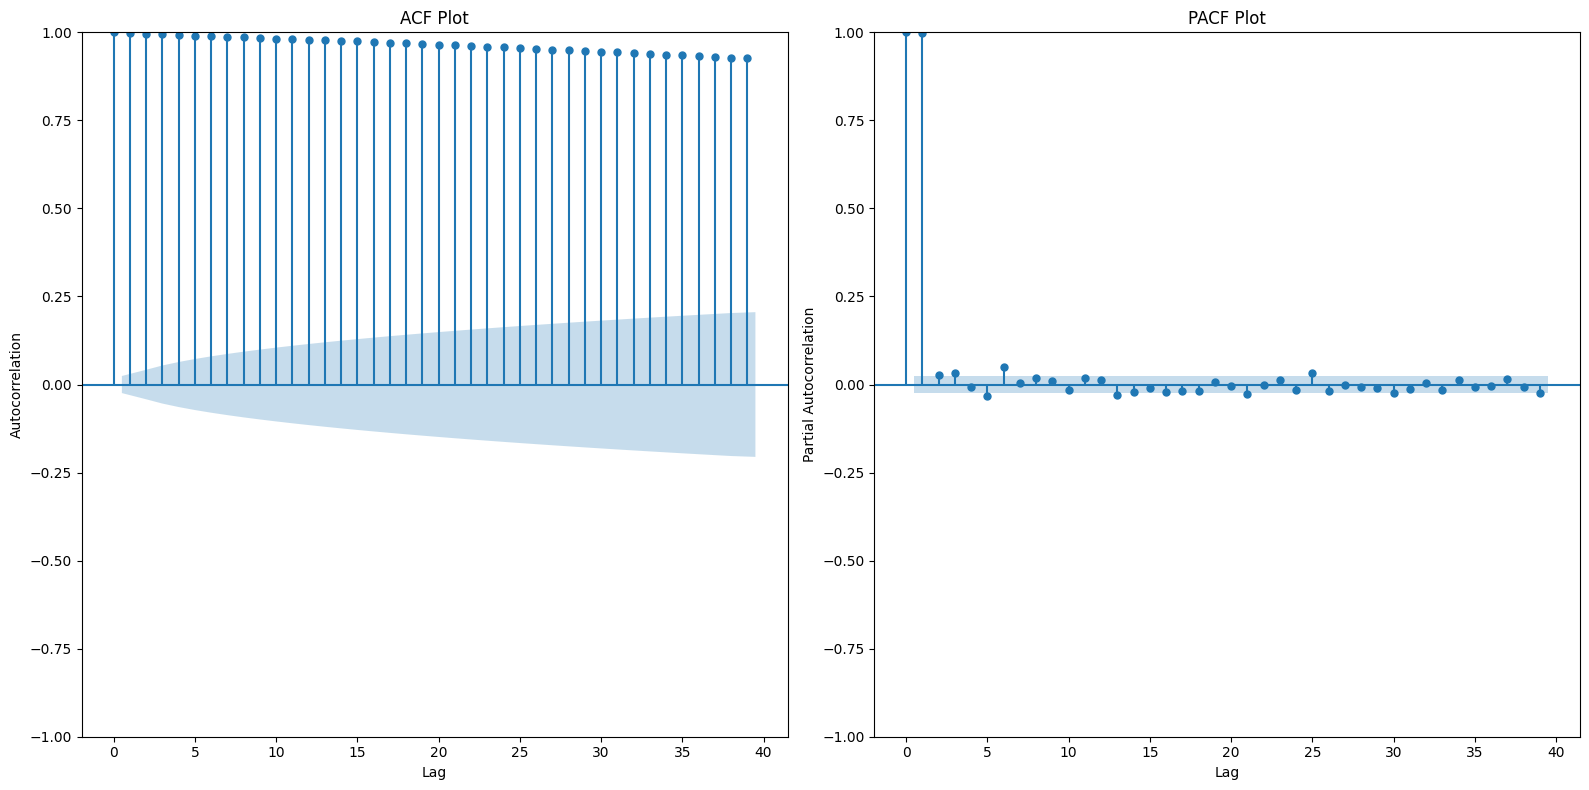

In [35]:
# Plot the acf 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Create figure and axes 
fig, ax = plt.subplots(1, 2, figsize=(16, 8)) 
# Plot ACF 
plot_acf(df1['value'], ax=ax[0]) 
ax[0].set_xlabel('Lag') 
ax[0].set_ylabel('Autocorrelation') 
ax[0].set_title('ACF Plot') 

# Plot PACF 
plot_pacf(df1['value'], ax=ax[1]) 
ax[1].set_xlabel('Lag') 
ax[1].set_ylabel('Partial Autocorrelation') 
ax[1].set_title('PACF Plot') 

# Show plots 
plt.tight_layout() 
plt.show()


The ACF showing slow decay suggests a correlation with longer lags which is sign of non-stationarity - this can be attributed to the strong trend as there is no seasonality in the data. Also the PACF show correlation drop off at lag=1. We will do the differencing (returns) to take care of this non-stationarity and plot ACF and PACF again

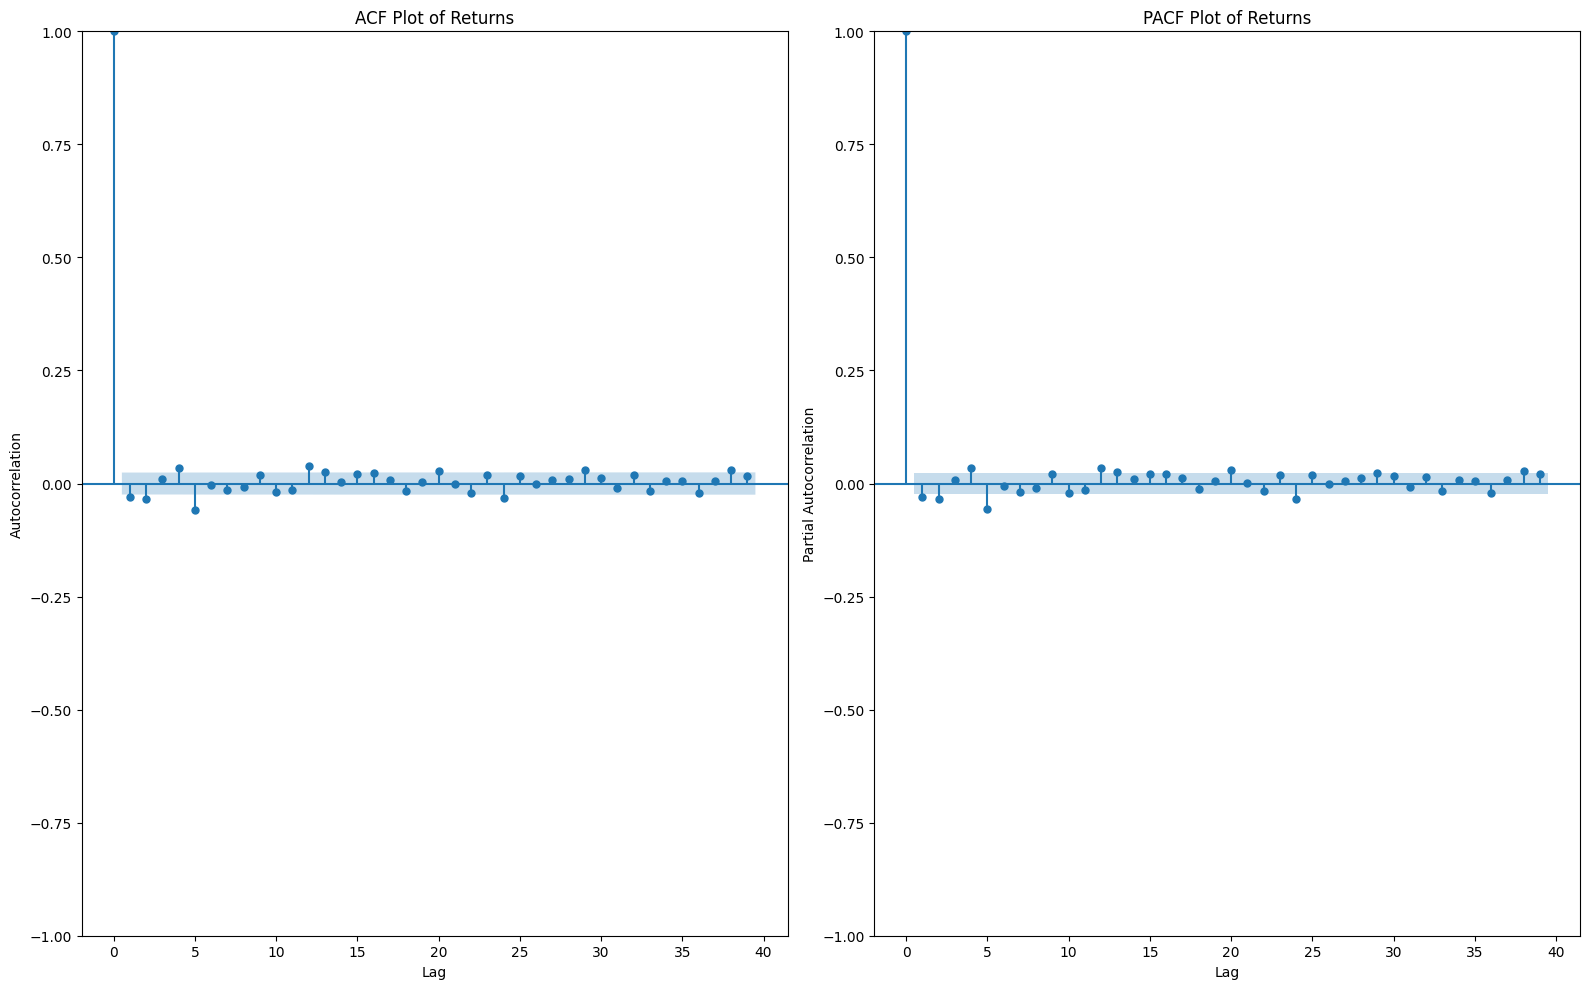

In [36]:
df1['diff'] = df1['value'].diff().dropna() 

fig, ax = plt.subplots(1, 2, figsize=(16, 10)) 

plot_acf(df1['diff'].dropna(), ax=ax[0]) 
ax[0].set_xlabel('Lag') 
ax[0].set_ylabel('Autocorrelation') 
ax[0].set_title('ACF Plot of Returns') 

plot_pacf(df1['diff'].dropna(), ax=ax[1]) 

ax[1].set_xlabel('Lag') 
ax[1].set_ylabel('Partial Autocorrelation') 
ax[1].set_title('PACF Plot of Returns') 

plt.tight_layout() 

plt.show()

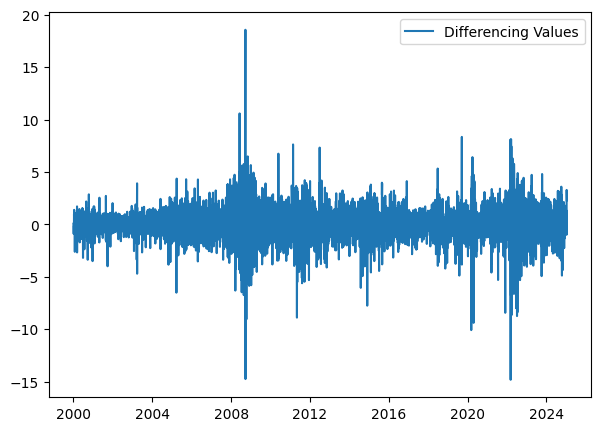

In [37]:
# Visualise the differencing to check if now stationary
plt.figure(figsize=(7,5))
plt.plot(df1['diff'], label='Differencing Values')
plt.legend()
plt.show;

The time series differencing is stationary with notable spikes and dip that would be from external shokes that affected oil prices.

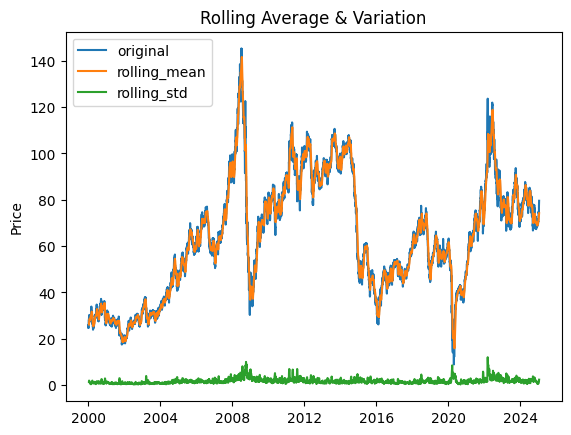

In [38]:
# Use rolling mean and std to further inspect for trends and seasonality
rolling_mean = df1['value'].rolling(window=12).mean()
rolling_std = df1['value'].rolling(window=12).std()
plt.plot(df1['value'], label='original')
plt.plot(rolling_mean, label='rolling_mean')
plt.plot(rolling_std, label='rolling_std')
plt.title("Rolling Average & Variation")
plt.ylabel('Price')
plt.legend()
plt.show;

Based on the observed trends in the original data and the rolling mean, we can conclude that the time series is non-stationary in line with previous analysis as well. A stationary time series should have a constant mean and variance over time, which is not the case here. We have a non-constant mean showing a upward trend , but the constant variation eliminates seasonality as visually seen from the data. There is no seasonal fluactuation in the price of crude oil (WTI). Spikes seen in 2008 and 2020 are easily explained from the global financial crisis of 2008 and Covid-19 in 2020.

# Modelling

### ARIMA Model

Based on the returns ACF & PACF, we would select an ARIMA model starting with (4, 1, 2). We will later carry out hyperparameter tuning for parameters (p, q, d) accordingly based on evaluations

In [39]:


# Fit ARIMA model on the data
model = ARIMA(df1['value'], order=(4, 1, 2))
model_fit = model.fit()

# Print model summary
print(model_fit.summary())


d:\OneDrive\Documents\Personal Project Portfolio\Financial_Analysis Web App_ Plotly Dash\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\OneDrive\Documents\Personal Project Portfolio\Financial_Analysis Web App_ Plotly Dash\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\OneDrive\Documents\Personal Project Portfolio\Financial_Analysis Web App_ Plotly Dash\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\OneDrive\Documents\Personal Pro

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                 6530
Model:                 ARIMA(4, 1, 2)   Log Likelihood              -11977.512
Date:                Sun, 19 Jan 2025   AIC                          23969.025
Time:                        16:47:47   BIC                          24016.513
Sample:                             0   HQIC                         23985.446
                               - 6530                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1596      0.058    -19.969      0.000      -1.273      -1.046
ar.L2         -0.8020      0.063    -12.772      0.000      -0.925      -0.679
ar.L3         -0.0551      0.011     -4.800      0.0

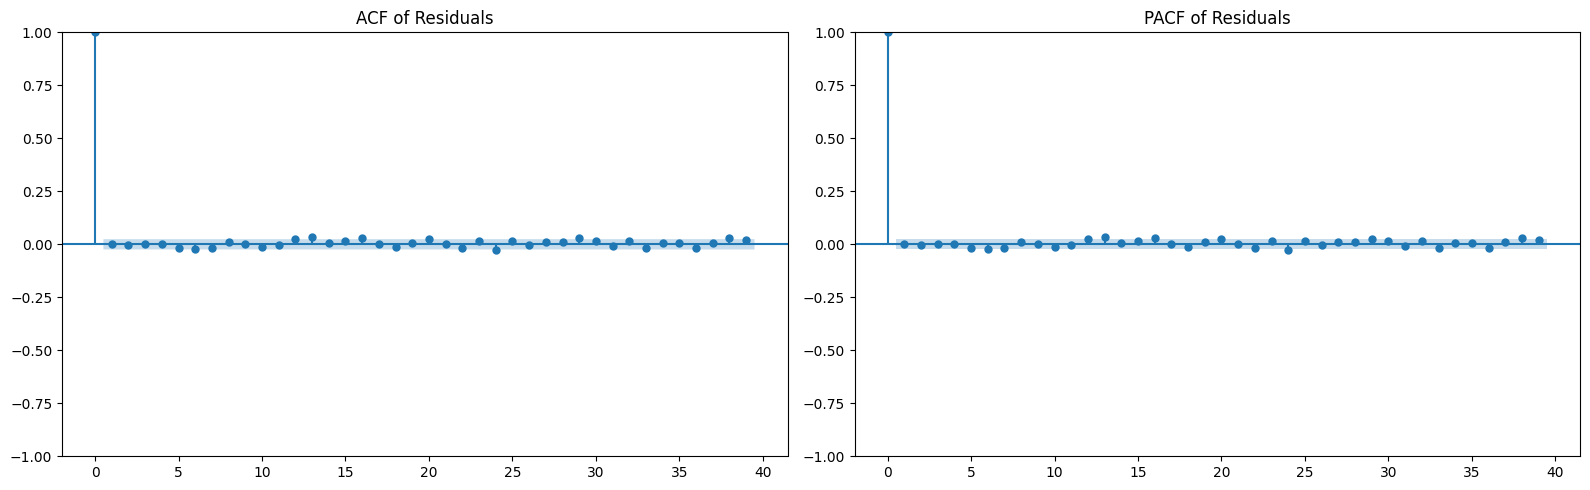

In [40]:
# Plot ACF and PACF of residuals
residuals = model_fit.resid

fig, ax = plt.subplots(1, 2, figsize=(16, 5))

plot_acf(residuals, ax=ax[0])
ax[0].set_title('ACF of Residuals')

plot_pacf(residuals, ax=ax[1])
ax[1].set_title('PACF of Residuals')

plt.tight_layout()
plt.show()


This shows the model is fitting well with no autocorrelation in the residuals. We will Remove the 4th AR since it is not significant from the result and try ARIMA(3,1,2). After we will perform out-of-sample forecast to evaluate the model

In [41]:
# Fit ARIMA model on the  data
model = ARIMA(df1['value'], order=(3, 1, 2))
model_fit = model.fit()

# Print model summary
print(model_fit.summary())

d:\OneDrive\Documents\Personal Project Portfolio\Financial_Analysis Web App_ Plotly Dash\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\OneDrive\Documents\Personal Project Portfolio\Financial_Analysis Web App_ Plotly Dash\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\OneDrive\Documents\Personal Project Portfolio\Financial_Analysis Web App_ Plotly Dash\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                 6530
Model:                 ARIMA(3, 1, 2)   Log Likelihood              -11977.772
Date:                Sun, 19 Jan 2025   AIC                          23967.543
Time:                        16:47:53   BIC                          24008.247
Sample:                             0   HQIC                         23981.619
                               - 6530                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2012      0.043    -28.118      0.000      -1.285      -1.117
ar.L2         -0.8651      0.043    -20.174      0.000      -0.949      -0.781
ar.L3         -0.0674      0.007     -9.779      0.0

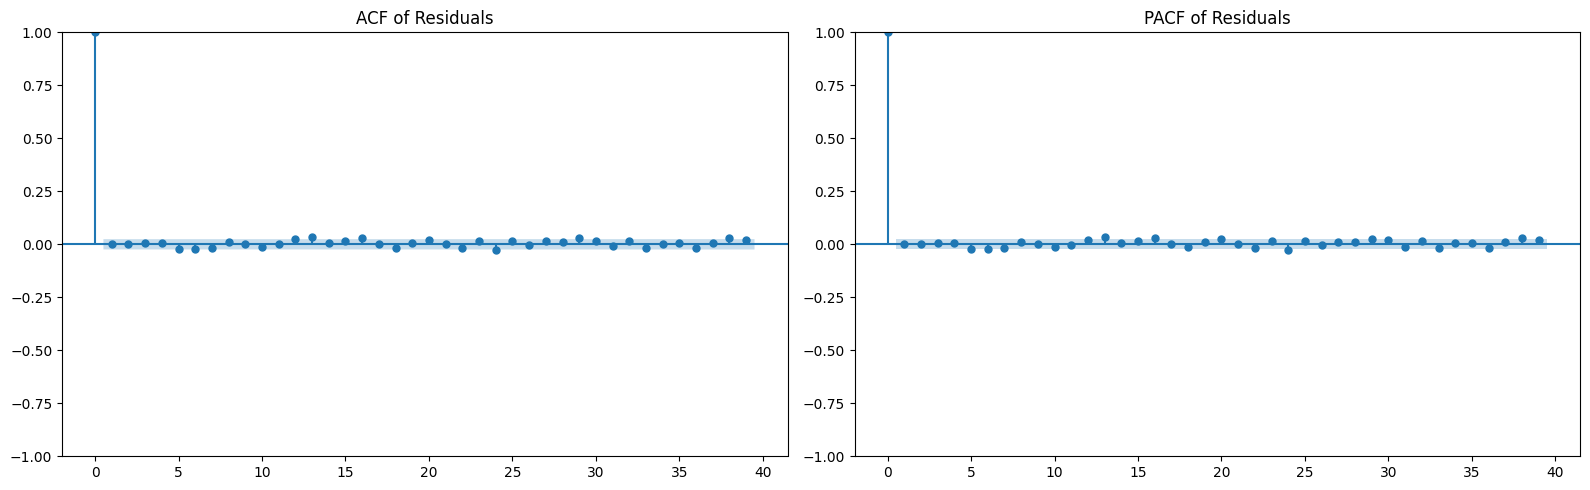

In [42]:
# Plot ACF and PACF of residuals
residuals = model_fit.resid

fig, ax = plt.subplots(1, 2, figsize=(16, 5))

plot_acf(residuals, ax=ax[0])
ax[0].set_title('ACF of Residuals')

plot_pacf(residuals, ax=ax[1])
ax[1].set_title('PACF of Residuals')

plt.tight_layout()
plt.show()

The model has good p-valus for AR & MA however, the residual skewness and Heteroskedasticity will need to be handled. The external shocks to oil price are likely to be the culpriit here.

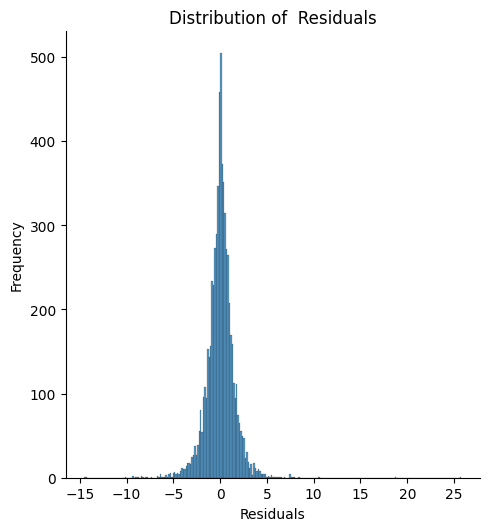

In [43]:
# Plot the distribution of the residuals
sns.displot(residuals)
plt.title('Distribution of  Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency');

In [44]:
# Split the data into training and test datasets
train_size = int(len(df1) * 0.8)

train_df = df1.iloc[:train_size]
test_df = df1.iloc[train_size:]



In [45]:
train_df

value  diff
date                   
2000-01-03  25.76   NaN
2000-01-04  25.56 -0.20
2000-01-05  24.65 -0.91
2000-01-06  24.79  0.14
2000-01-07  24.79  0.00
...           ...   ...
2020-01-03  63.00  1.83
2020-01-06  63.27  0.27
2020-01-07  62.70 -0.57
2020-01-08  59.65 -3.05
2020-01-09  59.56 -0.09

[5224 rows x 2 columns]

In [46]:
# Fit the model on the training dataset
model = ARIMA(train_df['value'], order=(3, 1, 2))
model_fit = model.fit()

d:\OneDrive\Documents\Personal Project Portfolio\Financial_Analysis Web App_ Plotly Dash\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
d:\OneDrive\Documents\Personal Project Portfolio\Financial_Analysis Web App_ Plotly Dash\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
d:\OneDrive\Documents\Personal Project Portfolio\Financial_Analysis Web App_ Plotly Dash\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


In [47]:
# Forecast for the test set period
start = len(train_df)
end = len(train_df) + len(test_df) - 1
forecast = model_fit.predict(start=start, end=end)

In [48]:
# Calculate accuracy metrics

mse = mean_squared_error(test_df['value'], forecast)
rmse = root_mean_squared_error(test_df['value'], forecast)

print('mean squared error:', mse)
print('root mean squared error:', rmse)

mean squared error: 549.0671222676256
root mean squared error: 23.432181338228535


In [49]:
# Plot the actual vs forecasted values
fig = px.line(train_df, x=train_df.index,  y=train_df['value'], 
              title='Actual vs Forecasted Values',
              labels={'value':"Price"},
              width=800,  
              height=500) 
fig.add_scatter(x=test_df.index, y=test_df['value'], mode='lines', name='Test Set')
fig.add_scatter(x=test_df.index, y=forecast, mode='lines', name='Forecast')

fig.show()


Let's use try a SARIMAX model 

In [50]:
# Fit the model on the training dataset
model = ARIMA(train_df['value'], order=(2, 1, 2), seasonal_order=(0, 0, 0, 365))
model_fit = model.fit()

d:\OneDrive\Documents\Personal Project Portfolio\Financial_Analysis Web App_ Plotly Dash\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.

d:\OneDrive\Documents\Personal Project Portfolio\Financial_Analysis Web App_ Plotly Dash\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.

d:\OneDrive\Documents\Personal Project Portfolio\Financial_Analysis Web App_ Plotly Dash\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.



In [51]:
# Forecast for the test set period
start = len(train_df)
end = len(train_df) + len(test_df) - 1
forecast = model_fit.predict(start=start, end=end)
print(forecast)

2020-01-10    59.608054
2020-01-13    59.493306
2020-01-14    59.468730
2020-01-15    59.534735
2020-01-16    59.547125
                ...    
2025-01-06    59.518911
2025-01-07    59.518911
2025-01-08    59.518911
2025-01-09    59.518911
2025-01-10    59.518911
Freq: B, Name: predicted_mean, Length: 1306, dtype: float64


In [52]:
# Calculate accuracy metrics

mse = mean_squared_error(test_df['value'], forecast)
rmse = root_mean_squared_error(test_df['value'], forecast)

print('mean squared error:', mse)
print('root mean squared error:', rmse)

mean squared error: 548.6573842368782
root mean squared error: 23.42343664445673


We do not have a different outcome, thus showing the issue is not seasonality but the random variation from external shock. We will use the Prophet and GARCH model which should be better suited to this type of data.

### Generalized Autoregressive Conditional Heteroskedasticity (GARCH) Modelling

In [53]:
from arch import arch_model

In [54]:
model = arch_model(df1['diff'].dropna(), vol='Garch', p=3, q=2)
model_fit = model.fit()

Iteration:      1,   Func. Count:      9,   Neg. LLF: 52653.01962571475
Iteration:      2,   Func. Count:     21,   Neg. LLF: 2375438.8840380083
Iteration:      3,   Func. Count:     31,   Neg. LLF: 11007.383141280512
Iteration:      4,   Func. Count:     40,   Neg. LLF: 10953.163539052443
Iteration:      5,   Func. Count:     49,   Neg. LLF: 1626409939.8158832
Iteration:      6,   Func. Count:     58,   Neg. LLF: 10982.550797115933
Iteration:      7,   Func. Count:     67,   Neg. LLF: 10855.940645820341
Iteration:      8,   Func. Count:     76,   Neg. LLF: 10923.390504901614
Iteration:      9,   Func. Count:     85,   Neg. LLF: 10823.830070322736
Iteration:     10,   Func. Count:     93,   Neg. LLF: 10967.141240472374
Iteration:     11,   Func. Count:    102,   Neg. LLF: 11134.1712126619
Iteration:     12,   Func. Count:    113,   Neg. LLF: 10822.223036456566
Iteration:     13,   Func. Count:    121,   Neg. LLF: 10822.052604277304
Iteration:     14,   Func. Count:    129,   Neg. LLF: 

In [55]:
print(model_fit.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   diff   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -10822.0
Distribution:                  Normal   AIC:                           21658.1
Method:            Maximum Likelihood   BIC:                           21705.6
                                        No. Observations:                 6529
Date:                Sun, Jan 19 2025   Df Residuals:                     6528
Time:                        16:48:24   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0305  1.436e-02      2.126  3.353e-02 [2.

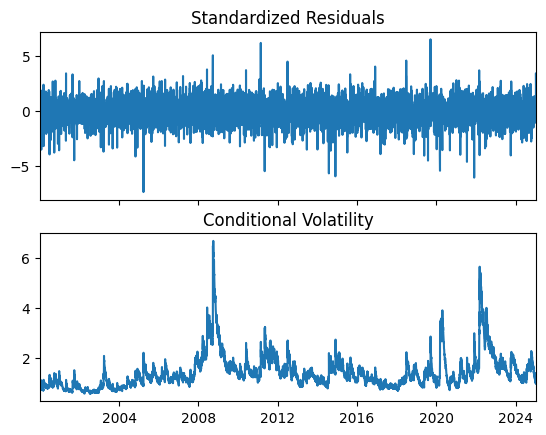

In [56]:
model_fit.plot()
plt.show()

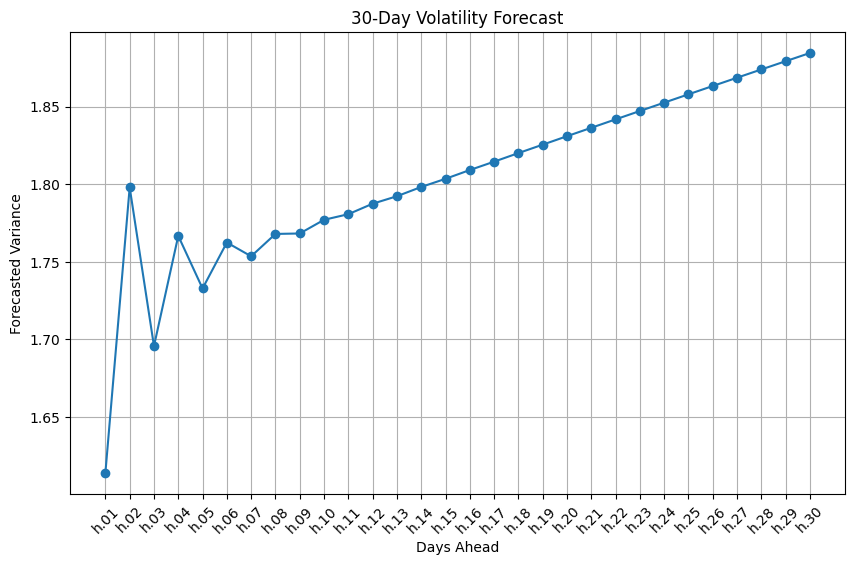

In [57]:

forecast = model_fit.forecast(horizon=30)

# Extract forecasted variance for the 10-day horizon
forecast_variance = forecast.variance.iloc[-1]

# Plot the forecasted variance (volatility)
plt.figure(figsize=(10, 6))
plt.plot(forecast_variance.index, forecast_variance.values, marker='o')
plt.title("30-Day Volatility Forecast")
plt.xlabel("Days Ahead")
plt.ylabel("Forecasted Variance")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()



In [58]:

forecast = model_fit.forecast(start=0, horizon=len(test_df))

In [76]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Extract forecasted volatility from the forecast object
forecasted_volatility = np.sqrt(forecast.variance.iloc[-len(test_df):].values)

# Calculate actual volatility (realized volatility) as the rolling standard deviation
actual_volatility = test_df['diff'].rolling(window=10).std().dropna().values  # Using a window of 10 for rolling volatility

# Trim the forecasted volatility to match the length of actual volatility
forecasted_volatility = forecasted_volatility[-len(actual_volatility):,1]

# Ensure both forecasted and actual volatility are arrays and have the same length
forecasted_volatility = np.array(forecasted_volatility)
actual_volatility = np.array(actual_volatility)

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(actual_volatility, forecasted_volatility))

print(f'RMSE: {rmse}')


RMSE: 0.4160307044484921


In [77]:
actual_volatility.shape

(1297,)

In [79]:
forecasted_volatility.shape

(1297,)

# PROPHET MODELLING

Next we would use Facebook Prophet model to see if we can take care of the complexity of external factors. As expected crude oil prices is affected by global economic and social issues which are not predictable without using some exogenous data.

In [82]:
# Instantiate the prophet model
model_fbp = Prophet()

In [111]:
# verify the training data we have
train_df.tail()

y
ds               
2020-01-03  63.00
2020-01-06  63.27
2020-01-07  62.70
2020-01-08  59.65
2020-01-09  59.56

In [87]:
# lets update a training DF for Prophet 
train_df.drop('diff', axis=1, inplace=True)

In [ ]:
# lets rename the DF as required in `fbprophet`
train_df_fbp = train_df.copy()
train_df_fbp.rename(columns={'value':'y'}, inplace=True)
train_df_fbp.index.name = 'ds'

In [103]:
# Confirm the training data column headings is ds and y
train_df_fbp.reset_index(inplace=True)

In [104]:
# Fit the training data to the model
model_fbp.fit(train_df_fbp)

19:10:33 - cmdstanpy - INFO - Chain [1] start processing
19:10:43 - cmdstanpy - INFO - Chain [1] done processing


In [115]:
# Create options for period(s) to forecast

forecast_period = interval[2]
period_dict = {'daily': 1, 'monthly': 30, 'yearly': 365}
n_select = 2

In [116]:
# Create a future DataFrame for forecasting
future = model_fbp.make_future_dataframe(periods=period_dict[forecast_period] * n_select)


In [117]:
# Make a forecast 
forecast = model_fbp.predict(future)

In [118]:
# Check the tail of the forecast to confirm period forecasted 
forecast.tail()

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
5949 2022-01-04  74.974134    8.051910  136.126898    14.554083   136.405572   
5950 2022-01-05  74.989365   12.658501  134.448219    14.502986   136.553710   
5951 2022-01-06  75.004596   11.059953  135.808212    14.451890   136.672397   
5952 2022-01-07  75.019827   12.336806  135.464200    14.400793   136.859315   
5953 2022-01-08  75.035058    6.495557  131.214914    14.349696   137.023973   

      additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
5949       -1.884158             -1.884158             -1.884158  1.129995   
5950       -1.835152             -1.835152             -1.835152  1.158520   
5951       -1.804248             -1.804248             -1.804248  1.172751   
5952       -1.732777             -1.732777             -1.732777  1.231525   
5953       -5.881252             -5.881252             -5.881252 -2.925543   

      weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
5949      1.129995      1.129995 -3.014153     -3.014153     -3.014153   
5950      1.158520      1.158520 -2.993672     -2.993672     -2.993672   
5951      1.172751      1.172751 -2.976999     -2.976999     -2.976999   
5952      1.231525      1.231525 -2.964302     -2.964302     -2.964302   
5953     -2.925543     -2.925543 -2.955709     -2.955709     -2.955709   

      multiplicative_terms  multiplicative_terms_lower  \
5949                   0.0                         0.0   
5950                   0.0                         0.0   
5951                   0.0                         0.0   
5952                   0.0                         0.0   
5953                   0.0                         0.0   

      multiplicative_terms_upper       yhat  
5949                         0.0  73.089976  
5950                         0.0  73.154213  
5951                         0.0  73.200347  
5952                         0.0  73.287049  
5953                         0.0  69.153806

In [135]:
# Plot the graph for the forecast
fig = plot_plotly(model_fbp, forecast)
fig.layout.update(title = f'{forecast_period}'.title() + " Forecast for " + f'{commodities[0]} ' + "(" +  f'{n_select}' + "-" +
                  f'{forecast_period}'[:-2] + ")",
                  xaxis_title= 'Date', yaxis_title='Price')
fig.show()


The prophet algorithm is strong to handle the complexity of the dataset. We will thus use this to handle the remaining commodities.

In [ ]:
# CRUDE OIL (BRENT)

In [137]:
# Download the brent data from Alpha Vantage
brent_data = cd.get_brent(interval[0])

In [138]:
# Confirm the data type of downloaded data
type(brent_data)

tuple

In [139]:
# Explore the downloaded tuple
brent_data

(            date  value
 0     2025-01-13  82.69
 1     2025-01-10  79.76
 2     2025-01-09  78.44
 3     2025-01-08  77.37
 4     2025-01-07  77.84
 ...          ...    ...
 9819  1987-05-26  18.63
 9820  1987-05-25  18.60
 9821  1987-05-22  18.55
 9822  1987-05-21  18.45
 9823  1987-05-20  18.63
 
 [9824 rows x 2 columns],
 None)

In [140]:
# Extract the DataFrame from the tuple adn explore the top 5 rows
brent_df = brent_data[0]
brent_df.head()

date  value
0  2025-01-13  82.69
1  2025-01-10  79.76
2  2025-01-09  78.44
3  2025-01-08  77.37
4  2025-01-07  77.84

In [141]:
# Explore the general information on the DataFrame
brent_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9824 entries, 0 to 9823
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    9824 non-null   object
 1   value   9824 non-null   object
dtypes: object(2)
memory usage: 153.6+ KB


There is no missing values, however there is need to clean the data for data type. The date should be datetime and value should be float.

In [142]:
# Convert date to datetime
brent_df['date'] = pd.to_datetime(brent_df['date'])

# Convert value to float
brent_df['value'] = brent_df['value'].astype('float')

ValueError: could not convert string to float: '.'

In [154]:
# let's check for values in the value column
pd.set_option('display.max_rows', None)
brent_df['value'].value_counts()

value
.         270
18.48      26
18.15      22
16.85      20
18.63      18
17.00      18
18.00      18
18.55      17
16.50      17
17.85      16
18.60      16
18.65      15
16.98      15
17.83      15
19.65      15
18.70      14
18.23      14
18.90      14
16.40      14
18.10      14
18.95      14
17.23      14
16.23      14
17.08      14
19.40      14
16.88      14
18.75      14
17.80      14
17.18      14
20.73      14
18.53      14
18.78      13
18.43      13
16.10      13
16.38      13
15.48      13
18.50      13
18.20      13
17.70      13
16.25      13
19.50      13
18.18      12
19.63      12
16.13      12
15.93      12
19.18      12
17.55      12
17.40      12
17.05      12
19.48      12
18.83      12
18.40      12
18.58      12
18.85      12
17.73      12
19.05      12
16.95      12
18.98      12
17.13      11
19.03      11
19.78      11
17.65      11
18.68      11
19.00      11
18.28      11
17.58      11
18.73      11
19.60      11
17.90      11
16.63      11
18.80      11


We will need to remove the `.` just like for `WTI` dataset

In [172]:
# Reset the display
pd.reset_option('all')
# Explore the instances of . as values further
len(brent_df[brent_df['value'] == '.'])

C:\Users\admin\AppData\Local\Temp\ipykernel_20376\711483956.py:2: FutureWarning:

data_manager option is deprecated and will be removed in a future version. Only the BlockManager will be available.

C:\Users\admin\AppData\Local\Temp\ipykernel_20376\711483956.py:2: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



0

In [157]:
# Replace . with nan
brent_df['value'] = brent_df['value'].replace('.', np.nan)

# Impute missing values with NaN
brent_df.bfill(inplace=True)

# Convert value column to float
brent_df['value'] = brent_df['value'].astype('float')

In [158]:
brent_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9824 entries, 0 to 9823
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    9824 non-null   datetime64[ns]
 1   value   9824 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 153.6 KB


This shows that we have the same issues with the Alpha Vantage datasets, thus, we will define the same pipeline for loading and transforming the data

In [174]:
# Convert the dataset to a time series
brent_df.set_index('date', inplace=True)

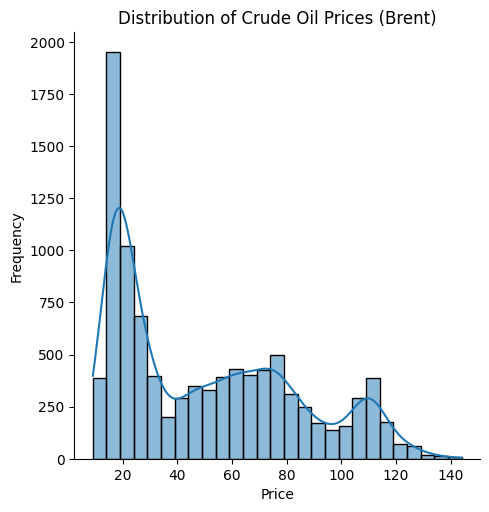

In [175]:
# Plot the distribution of the data
sns.displot(brent_df['value'], kind='hist', kde=True)
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.title('Distribution of Crude Oil Prices (Brent)');

Just like for WTI, the data is skewed to the right showing few periods of very high crude oil prices within the period. We will plot the trend to see how this looks like

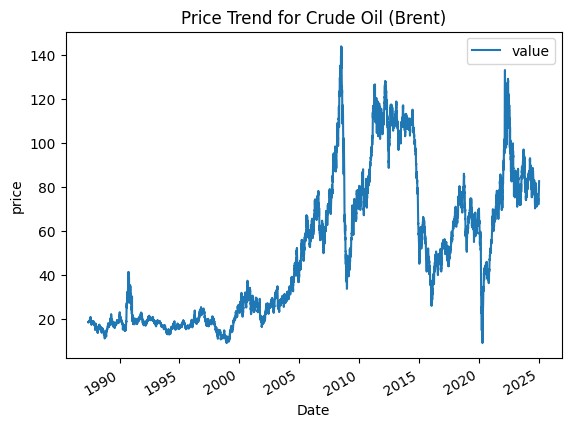

In [178]:
# Plot the trend line for the whole period
brent_df.plot()
plt.title('Price Trend for Crude Oil (Brent)')
plt.xlabel('Date')
plt.ylabel("price")
plt.show();

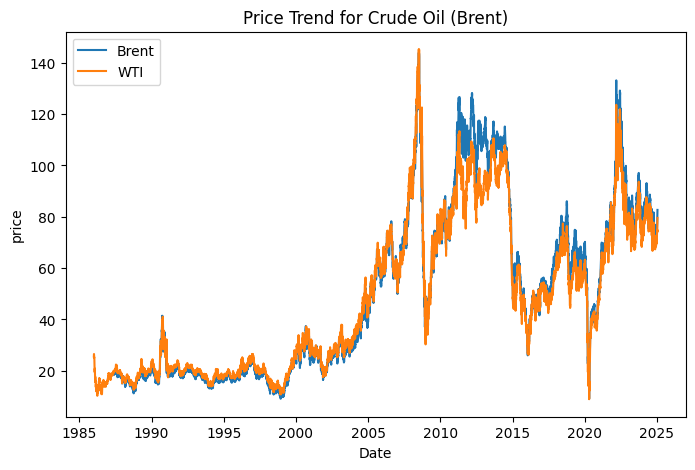

In [195]:
# We will compare this with crude oil (WTI) prices

fig , ax = plt.subplots(figsize=(8, 5))
plt.plot(brent_df, label='Brent')
plt.plot(df, label='WTI')
plt.title('Price Trend for Crude Oil (Brent)')
plt.xlabel('Date')
plt.ylabel("price")
plt.legend()
plt.show();

Both types of crude oil follow similar trend such we can use the same model to predict i.e. Prophet

In [196]:
# Split the data into training and test datasets
train_size = int(len(brent_df) * 0.8)

train_df_brent = brent_df.iloc[:train_size]
test_df_brent = brent_df.iloc[train_size:]

print('The shape of the train data is:', train_df_brent.shape)
print('The shape of the test data is:', test_df_brent.shape)

The shape of the train data is: (7859, 1)
The shape of the test data is: (1965, 1)


In [301]:
# Create a function to prepare data for training with prophet
def prep_train_data_prophet(df):
    # lets rename the DF as required in `fbprophet`
    df_fbp = df.copy()
    df_fbp.reset_index(inplace=True)
    df_fbp.rename(columns={'value':'y', 'date': 'ds'}, inplace=True)
    df_fbp = df_fbp[['ds', 'y']]
    df_fbp.sort_values('ds',inplace=True)
    train_size = int(len(df_fbp) * 0.8)

    train_df_brent = df_fbp.iloc[:train_size]
    test_df_brent = df_fbp.iloc[train_size:]

    
    return train_df_brent , test_df_brent

In [302]:
train_df_brent, test_df_brent = prep_train_data_prophet(brent_df)

In [303]:
train_df_brent

ds      y
9823 1987-05-20  18.63
9822 1987-05-21  18.45
9821 1987-05-22  18.55
9820 1987-05-25  18.60
9819 1987-05-26  18.63
...         ...    ...
1969 2017-06-27  46.17
1968 2017-06-28  46.45
1967 2017-06-29  47.02
1966 2017-06-30  47.08
1965 2017-07-03  49.13

[7859 rows x 2 columns]

In [304]:
test_df_brent

ds      y
1964 2017-07-04  49.15
1963 2017-07-05  47.58
1962 2017-07-06  48.53
1961 2017-07-07  46.47
1960 2017-07-10  46.57
...         ...    ...
4    2025-01-07  77.84
3    2025-01-08  77.37
2    2025-01-09  78.44
1    2025-01-10  79.76
0    2025-01-13  82.69

[1965 rows x 2 columns]

In [305]:
print('The shape of the train data is:', train_df_brent.shape)
print('The shape of the test data is:', test_df_brent.shape)

The shape of the train data is: (7859, 2)
The shape of the test data is: (1965, 2)


In [306]:
model_fbp = Prophet()
model_fbp.fit(train_df_brent)

22:53:28 - cmdstanpy - INFO - Chain [1] start processing
22:53:43 - cmdstanpy - INFO - Chain [1] done processing


In [307]:
# Forecast for the test set period

future = model_fbp.make_future_dataframe(periods=len(test_df_brent))
forecast = model_fbp.predict(future)

In [308]:
forecast

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0    1987-05-20  16.199845    4.046507   29.764504    16.199845    16.199845   
1    1987-05-21  16.203640    4.962324   29.146202    16.203640    16.203640   
2    1987-05-22  16.207435    4.400162   29.397263    16.207435    16.207435   
3    1987-05-25  16.218820    4.654730   29.341137    16.218820    16.218820   
4    1987-05-26  16.222615    5.953029   28.871455    16.222615    16.222615   
...         ...        ...         ...         ...          ...          ...   
9819 2022-11-15 -39.240497 -130.707178   63.885388  -131.613883    63.390815   
9820 2022-11-16 -39.280248 -135.681767   64.945332  -131.741116    63.477653   
9821 2022-11-17 -39.319998 -135.265109   65.986822  -131.843134    63.563760   
9822 2022-11-18 -39.359748 -136.488725   60.105437  -131.945151    63.649866   
9823 2022-11-19 -39.399498 -132.140487   62.856226  -132.047169    63.735972   

      additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
0           0.705863              0.705863              0.705863 -0.455834   
1           0.813233              0.813233              0.813233 -0.374158   
2           0.839086              0.839086              0.839086 -0.373819   
3           0.868869              0.868869              0.868869 -0.413536   
4           0.844411              0.844411              0.844411 -0.456992   
...              ...                   ...                   ...       ...   
9819       -1.675650             -1.675650             -1.675650 -0.456992   
9820       -1.687068             -1.687068             -1.687068 -0.455834   
9821       -1.618091             -1.618091             -1.618091 -0.374158   
9822       -1.631424             -1.631424             -1.631424 -0.373819   
9823       -0.235884             -0.235884             -0.235884  1.037170   

      weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
0        -0.455834     -0.455834  1.161697      1.161697      1.161697   
1        -0.374158     -0.374158  1.187391      1.187391      1.187391   
2        -0.373819     -0.373819  1.212905      1.212905      1.212905   
3        -0.413536     -0.413536  1.282405      1.282405      1.282405   
4        -0.456992     -0.456992  1.301403      1.301403      1.301403   
...            ...           ...       ...           ...           ...   
9819     -0.456992     -0.456992 -1.218658     -1.218658     -1.218658   
9820     -0.455834     -0.455834 -1.231234     -1.231234     -1.231234   
9821     -0.374158     -0.374158 -1.243933     -1.243933     -1.243933   
9822     -0.373819     -0.373819 -1.257605     -1.257605     -1.257605   
9823      1.037170      1.037170 -1.273054     -1.273054     -1.273054   

      multiplicative_terms  multiplicative_terms_lower  \
0                      0.0                         0.0   
1                      0.0                         0.0   
2                      0.0                         0.0   
3                      0.0                         0.0   
4                      0.0                         0.0   
...                    ...                         ...   
9819                   0.0                         0.0   
9820                   0.0                         0.0   
9821                   0.0                         0.0   
9822                   0.0                         0.0   
9823                   0.0                         0.0   

      multiplicative_terms_upper       yhat  
0                            0.0  16.905709  
1                            0.0  17.016873  
2                            0.0  17.046521  
3                            0.0  17.087689  
4                            0.0  17.067026  
...                          ...        ...  
9819                         0.0 -40.916148  
9820                         0.0 -40.967315  
9821                         0.0 -40.938089  
9822                         0.0 -40.991172  
9823                   

In [309]:
forecast[-len(test_df_brent['y']):].yhat

7859    39.650196
7860    39.647009
7861    39.723293
7862    39.716817
7863    41.119232
          ...    
9819   -40.916148
9820   -40.967315
9821   -40.938089
9822   -40.991172
9823   -39.635382
Name: yhat, Length: 1965, dtype: float64

In [310]:
# Calculate accuracy metrics

mse = mean_squared_error(test_df_brent['y'], forecast[-len(test_df_brent['y']):].yhat)
rmse = root_mean_squared_error(test_df_brent['y'], forecast[-len(test_df_brent['y']):].yhat)

print('mean squared error:', mse)
print('root mean squared error:', rmse)

mean squared error: 6525.838504482687
root mean squared error: 80.78266215273354


In [311]:
# Plot the actual vs forecasted values
fig = px.line(train_df_brent, x=train_df_brent['ds'],  y=train_df_brent['y'], 
              title='Actual vs Forecasted Values',
              labels={'value':"Price"},
              width=800,  
              height=500) 
fig.add_scatter(x=test_df_brent['ds'], y=test_df_brent['y'], mode='lines', name='Test Set')
fig.add_scatter(x=test_df_brent['ds'], y=forecast[-len(test_df_brent['y']):].yhat, mode='lines', name='Forecast')

fig.show()

In [312]:
# Plot the graph for the forecast
fig = plot_plotly(model_fbp, forecast)
# fig.layout.update(title = f'{forecast_period}'.title() + " Forecast for " + f'{commodities[0]} ' + "(" +  f'{n_select}' + "-" +
#                   f'{forecast_period}'[:-2] + ")",
#                   xaxis_title= 'Date', yaxis_title='Price')
fig.show()